# DA3 Assignment 2
## Finding fast growing firms - data preparation
Presented by: Yllke Berisha & Bo Wang

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
path = os.getcwd()
base_dir = path.split("da_case_studies")[0]

data_dir = base_dir + "da_data_repo"


In [3]:
# location folders
data_in = os.path.join(data_dir, "bisnode-firms/clean/")
data_out = os.path.join(data_dir, "bisnode-firms/")
output = os.path.join(data_out, "output/")
func = path  # helper functions live in the notebook folder
sys.path.append(func)


In [4]:
# Import the prewritten helper functions
import py_helper_functions as da

sns.set_theme(rc=da.da_theme, palette=da.color)


# Import data

In [5]:
csv_path = os.path.join(data_in, "cs_bisnode_panel.csv")

# Use the OSF mirror if the local file is unavailable.
data = pd.read_csv("https://osf.io/download/3qyut/")

In [6]:
# drop variables with many NAs
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)
data = data.query("year !=2016")



# Label engineering


In [7]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN


In [8]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)



In [9]:
data = data.query("year <= 2013")

In [10]:
data["sales"].describe()


count     215119.0
unique     72334.0
top            0.0
freq       30518.0
Name: sales, dtype: float64

In [11]:
# Replace negative sales with 1 while preserving Series type
data["sales"] = data["sales"].clip(lower=1)

# Use astype to ensure proper float64 dtype before calling np.log
data["ln_sales"] = np.log(data["sales"].astype('float64'))
data["sales_mil"] = data["sales"] / 1000000
data["sales_mil_log"] = np.log(data["sales_mil"].astype('float64'))

In [ ]:
# Calculate year-over-year (2012-2011) sales change (log difference) for each firm
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)


In [13]:
# replace w 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)


In [14]:
# --- Added: compute future growth (Future Growth) ---
# Ensure data is sorted by company and year
data = data.sort_values(by=['comp_id', 'year'])

# Use shift(-1) to get the "next row" (i.e., 2013) sales
data['sales_mil_log_future'] = data.groupby('comp_id')['sales_mil_log'].shift(-1)

# Compute future growth rate (2013 - 2012)
data['future_growth_rate'] = data['sales_mil_log_future'] - data['sales_mil_log']

In [15]:
# -------------------------------------------------------------------------
# NEW TARGET DEFINITION: FAST GROWTH
# -------------------------------------------------------------------------

# 1. Define the threshold for fast growth 
# (e.g., 20% growth corresponds to a log difference of approx 0.182)
growth_threshold = 0.182 

# 2. Generate the target variable 'fast_growth'
# Logic: If annual sales growth exceeds the threshold, label as 1, otherwise 0.
data['fast_growth'] = (data['future_growth_rate'] > growth_threshold).astype(int)

# 3. Handle missing values
# If the growth rate itself is missing, ensure the target is set to NaN so it can be filtered later.
data.loc[data['future_growth_rate'].isna(), 'fast_growth'] = np.nan

# 4. Check the distribution (Base Rate)
# It is important to check if we have enough positive cases (aim for ~15-25%).
print("Fast Growth Distribution (Before Filter):")
print(data['fast_growth'].value_counts(normalize=True))

Fast Growth Distribution (Before Filter):
fast_growth
0.0    0.698631
1.0    0.301369
Name: proportion, dtype: float64


In [16]:
data["new"].describe()


count    417708.000000
mean          0.704597
std           0.456224
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

# Sample design

In [17]:
# look at cross section
data = data.query("year==2012 & status_alive == 1")
# look at firms below 10m euro revenues and above 1000 euros
data = data.query("sales_mil<=10 & sales_mil>=0.001")
data = data.dropna(subset=['fast_growth'])


In [18]:
data["fast_growth"].describe()


count    20086.000000
mean         0.304391
std          0.460161
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: fast_growth, dtype: float64

In [19]:
os.makedirs(data_out, exist_ok=True)
data.to_csv(data_out + "work5.csv", index=False)


# Feature engineering

In [20]:
current_csv_path = os.path.join(data_out, "work5.csv")
data = pd.read_csv(current_csv_path)


In [21]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])


In [22]:
data.groupby("ind2_cat").count()["comp_id"]


ind2_cat
20.0       50
26.0     1040
27.0      629
28.0     1881
29.0      271
30.0      161
32.0      137
33.0     1867
40.0      199
55.0     2167
56.0    11450
60.0      229
99.0        5
Name: comp_id, dtype: int64

In [23]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")


In [24]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]


flag_asset_problem
0.0    20068
1.0       11
Name: comp_id, dtype: int64

In [25]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])


In [26]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()


count    2.007900e+04
mean     2.671181e+05
std      1.432999e+06
min      0.000000e+00
25%      7.166667e+03
50%      2.596667e+04
75%      1.016574e+05
max      1.046833e+08
Name: total_assets_bs, dtype: float64

In [27]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]


In [28]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)


In [29]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )


In [30]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)


In [31]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [32]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)


In [33]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [34]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)


In [35]:
data["labor_avg"].describe()


count    17200.000000
mean         0.641504
std          1.628285
min          0.083333
25%          0.097222
50%          0.234848
75%          0.527778
max         42.118057
Name: labor_avg, dtype: float64

In [36]:
data["labor_avg_mod"].describe()


count    20086.000000
mean         0.641504
std          1.506767
min          0.083333
25%          0.125000
50%          0.295455
75%          0.641504
max         42.118057
Name: labor_avg_mod, dtype: float64

In [37]:
data = data.drop(["labor_avg"], axis=1)


In [38]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")


In [39]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2


In [40]:
########################################################################
# sales change
########################################################################
# Note: graphs not in book

# lowess
data["d1_sales_mil_log"].describe()


count    20086.000000
mean         0.115659
std          1.278277
min         -5.504762
25%         -0.135197
50%          0.000000
75%          0.127221
max         14.452352
Name: d1_sales_mil_log, dtype: float64

In [41]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2


In [42]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])


In [43]:
# drop missing
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()


count    17650.000000
mean         8.932465
std          6.941127
min          0.000000
25%          2.000000
50%          8.000000
75%         15.000000
max         32.000000
Name: age, dtype: float64

In [44]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()


Text(0.5, 0, 'Growth rate (Diff of ln sales)')

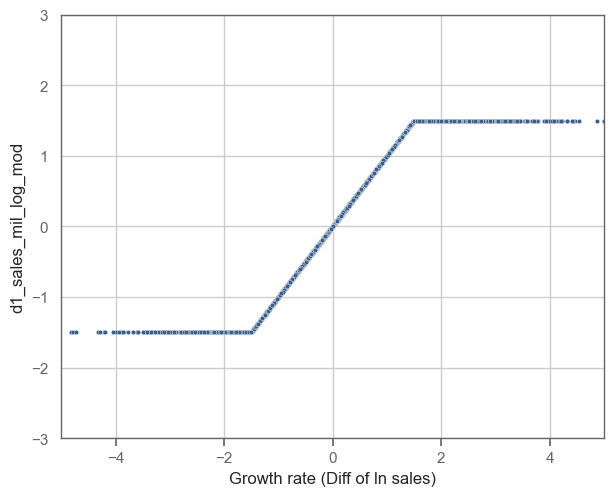

In [45]:
sns.scatterplot(x="d1_sales_mil_log", y="d1_sales_mil_log_mod", s=10, data=data)
plt.xlim(-5, 5)
plt.ylim(-3, 3)
plt.xlabel("Growth rate (Diff of ln sales)")

In [46]:
data.to_csv(data_out + "bisnode_firms_clean.csv", index=False)


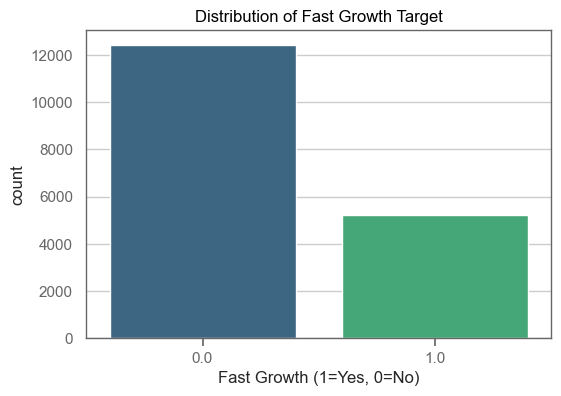

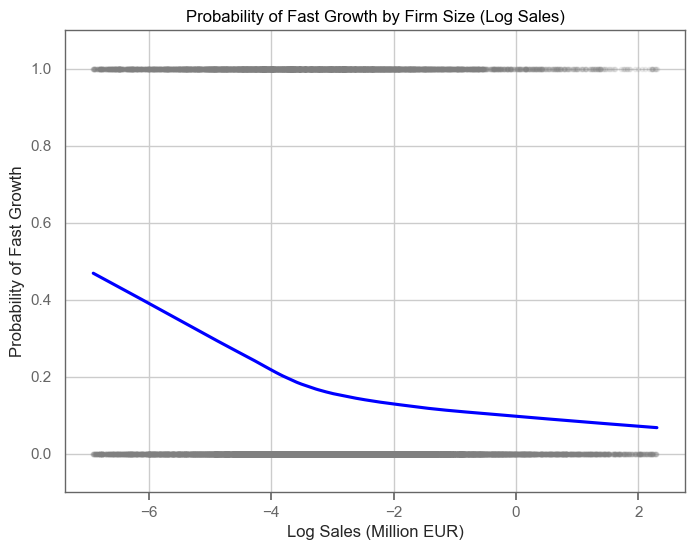

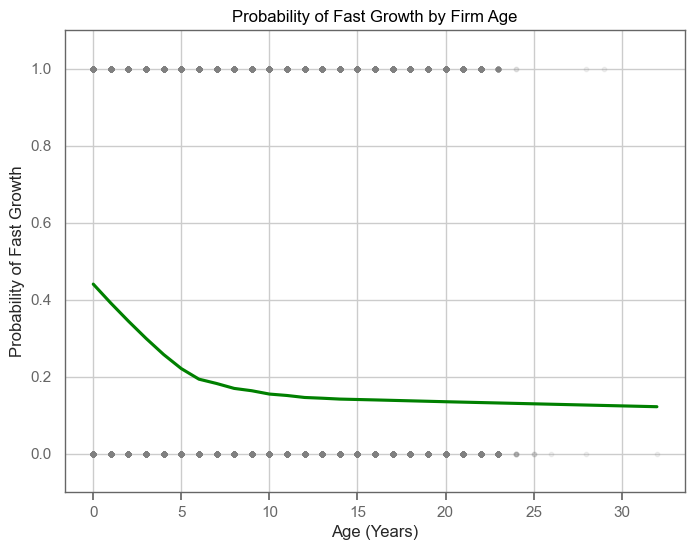

In [47]:
# -------------------------------------------------------------------------
# VISUALIZATION: FAST GROWTH RELATIONSHIPS
# -------------------------------------------------------------------------

# 1. Check target distribution (make sure it is not extremely imbalanced)
plt.figure(figsize=(6, 4))
sns.countplot(x="fast_growth", data=data, palette="viridis")
plt.title("Distribution of Fast Growth Target")
plt.xlabel("Fast Growth (1=Yes, 0=No)")
plt.show()

# 2. Loess Plot: Firm size (Log Sales) vs probability of fast growth
# This shows whether larger or smaller firms are more likely to grow fast.
plt.figure(figsize=(8, 6))
sns.regplot(
    x="sales_mil_log",
    y="fast_growth",
    data=data,
    lowess=True,
    scatter_kws={"alpha": 0.1, "s": 10, "color": "grey"},  # fade points to highlight the curve
    line_kws={"color": "blue"},
)
plt.title("Probability of Fast Growth by Firm Size (Log Sales)")
plt.xlabel("Log Sales (Million EUR)")
plt.ylabel("Probability of Fast Growth")
plt.ylim(-0.1, 1.1)
plt.show()

# 3. Loess Plot: Firm age vs probability of fast growth
# This shows whether younger or older firms are more likely to grow fast.
plt.figure(figsize=(8, 6))
sns.regplot(
    x="age",
    y="fast_growth",
    data=data,
    lowess=True,
    scatter_kws={"alpha": 0.1, "s": 10, "color": "grey"},
    line_kws={"color": "green"},
)
plt.title("Probability of Fast Growth by Firm Age")
plt.xlabel("Age (Years)")
plt.ylabel("Probability of Fast Growth")
plt.ylim(-0.1, 1.1)
plt.show()